In [1]:
import numpy as np
from numpy import random
from numpy.random import choice

import pandas as pd

import scipy.stats as ss

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from Visualize import Visualize
from Simulation import Simulation, show_deltas_distribution, init_sim_draw_deltas
from Metric import Metric

from tqdm.auto import tqdm

import torch
from torch import nn
from torch.nn import functional as F

from utils import powerset, powerset_bounded, choose_indices, choose_indices_bounded
from utils import print_func_names, print_indices
from params_modification import p_norm, modify_params, L1, L2, L4, geom_mean, arifm_mean
from metrics_signals import signals, metrics

In [2]:
random.seed(40)
SIZE = 1000
N_USERS = 1000
N_ITERATIONS = 1000
eps = 1e-8

In [3]:
# metrics

def ctr(data):
    return data.iloc[:, 0:2].min(axis=1) / (data.iloc[:, 0:2].max(axis=1) + eps)

def clip_ctr(data):
    return np.clip(data.iloc[:, 0:2].min(axis=1) / (data.iloc[:, 0:2].max(axis=1) + eps), 0, 1)

def queries_per_user(data):
    return data.iloc[:, 2]

def sessions_per_user(data):
    return data.iloc[:, 3]

def queries_per_session(data):
    return np.clip(data.iloc[:, 2] / (data.iloc[:, 3] + eps), 0, 1)

def ads_click_rate(data):
    return np.clip(data.iloc[:, 4] / (queries_per_user(data) + eps), 0, 1)

def page_load_time_per_user(data):
    return data.iloc[:, 5]

def log_record_size_per_user(data):
    return data.iloc[:, 6]

def time_to_click_per_user(data):
    return data.iloc[:, 7]

def time_spent_per_user(data):
    return data.iloc[:, 8]


In [4]:
# signals

def expon(param, n_users=N_USERS):
    return ss.expon.rvs(loc=param, size=n_users)

def expon2(param, n_users=N_USERS):
    return ss.expon.rvs(loc=param, size=n_users)

def n_queries(param, n_users=N_USERS):
    return ss.poisson.rvs(mu=param, size=n_users)

def n_sessions(param, n_users=N_USERS):
    return ss.poisson.rvs(mu=param, size=n_users)

def n_sessions_with_ads_clicks(param, n_users=N_USERS):
    return ss.poisson.rvs(mu=param, size=n_users)

def page_load_time(param, n_users=N_USERS):
    return ss.lognorm.rvs(s=0.3, loc=param, size=n_users)

def log_record_size(param, n_users=N_USERS):
    return ss.poisson.rvs(mu=param, size=n_users)

def time_to_click(param, n_users=N_USERS):
    return ss.lognorm.rvs(s=0.8, loc=param, size=n_users)

def time_spent(param, n_users=N_USERS):
    return ss.lognorm.rvs(s=0.9, loc=param, size=n_users)


## Генерация симуляции

In [5]:
signals = [expon, expon2, n_queries, n_sessions,
           n_sessions_with_ads_clicks, page_load_time,
           log_record_size, time_to_click, time_spent]

metrics = [ctr, clip_ctr, queries_per_user, sessions_per_user,
           queries_per_session, ads_click_rate, page_load_time_per_user,
           log_record_size_per_user, time_to_click_per_user,
           time_spent_per_user]

functions = [L1, L2, L4, geom_mean, arifm_mean]

In [6]:
init_params = np.array([0.1, 0.5, 1, 2, 5, 10, 15, 20, 30])
coeffs_factors = [0.1, 0.3, 0.5, 1.2, 1.5, 2, 5, 10]
transform_functions = []
n_params = len(init_params)

for i in range(n_params):
    transform_functions.append(choice(functions))

expon_indices = 0
expon2_indices = 0
n_queries_indices = 0
n_sessions_indices = 0
n_sessions_with_ads_clicks_indices = 0
page_load_time_indices = 0
log_record_size_indices = 0
time_to_click_indices = 0
time_spent_indices = 0

indices = [expon_indices, expon2_indices, n_queries_indices, n_sessions_indices,
           n_sessions_with_ads_clicks_indices, page_load_time_indices,
           log_record_size_indices, time_to_click_indices, time_spent_indices]

for i in range(len(indices)):
    indices[i] = np.array(choose_indices_bounded(np.arange(n_params), 5))

print("Transform_functions:\n")
print_func_names(transform_functions)

print("Indices:\n")
print_indices(indices)

Transform_functions:

0:    geom_mean
1:    L1
2:    L1
3:    L4
4:    L2
5:    arifm_mean
6:    L4
7:    geom_mean
8:    L4


Indices:

0:      [0 2 6]
1:      [1 4 5 7]
2:      [1 2 3 6]
3:      [1 6 7]
4:      [1 2 3]
5:      [2 3 5 6]
6:      [0 1 6]
7:      [0 5 6 7]
8:      [1 2 3]




D:\My Files\HSE\4 module, 2021\Course project\New\utils.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ind = list(choice(pws))


In [72]:
#init_sim_draw_deltas()

## Обучение нейронных метрик

In [11]:
def gen_train_test(init_params, transform_functions, indices, coeff_ind, coeff_factor,
                   signals, metrics, n_train, n_test):
    params = modify_params(init_params, transform_functions, indices)

    sim = Simulation()

    sim.add_signals(signals)
    sim.set_params(params)

    sim.add_metrics(metrics)

    ms_old_train = []
    ms_new_train = []
    
    ms_old_test = []
    ms_new_test = []
    
    
    for j in range(len(coeff_ind)):
        coeffs = np.ones_like(init_params)
        coeffs[coeff_ind[j]] *= coeff_factor[j]
        
        for k in range(n_train):
            ms_old_k = []
            ms_new_k = []
            for u in range(10):
                sim.set_params(params)
                sim.generate_data()
                metrics_res1 = sim.conduct_metrics()
                ms_old_k.append(metrics_res1)

                sim.set_params(params * coeffs)
                sim.generate_data()
                metrics_res2 = sim.conduct_metrics()
                ms_new_k.append(metrics_res2)

            ms_old_train.append(ms_old_k)
            ms_new_train.append(ms_new_k)

        for k in range(n_test):
            ms_old_k = []
            ms_new_k = []
            for u in range(10):
                sim.set_params(params)
                sim.generate_data()
                metrics_res1 = sim.conduct_metrics()
                ms_old_k.append(metrics_res1)

                sim.set_params(params * coeffs)
                sim.generate_data()
                metrics_res2 = sim.conduct_metrics()
                ms_new_k.append(metrics_res2)

            ms_old_test.append(ms_old_k)
            ms_new_test.append(ms_new_k)
    
    ms_old_train = torch.FloatTensor(ms_old_train)
    ms_old_test = torch.FloatTensor(ms_old_test)
    
    ms_new_train = torch.FloatTensor(ms_new_train)
    ms_new_test = torch.FloatTensor(ms_new_test)
    
    return ms_old_train, ms_new_train, ms_old_test, ms_new_test


def train(model, epochs, ms_old_train, ms_new_train, ms_old_test, ms_new_test,
          answers_train, answers_test, weight_decay=1e-5):
    
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)
    global_train_losses = []
    global_test_losses = []

    for i in tqdm(range(epochs)):
        train_losses = []
        test_losses = []
        
        for k in range(len(ms_old_train)):
            loss = 0
            for j in range(len(ms_old_train[k])):
                loss += (model(ms_new_train[k][j]) - model(ms_old_train[k][j]))
            loss /= len(ms_old_train[k])
            loss = (loss - answers_train[k]) ** 2
            
            train_losses.append(loss)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        for k in range(len(ms_old_test)):
            loss = 0
            for j in range(len(ms_old_test[k])):
                loss += (model(ms_new_test[k][j]) - model(ms_old_test[k][j]))
            loss /= len(ms_old_test[k])
            loss = (loss - answers_test[k]) ** 2
            
            test_losses.append(loss)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        global_train_losses.append(torch.FloatTensor(train_losses).mean().item())
        global_test_losses.append(torch.FloatTensor(test_losses).mean().item())
    
    fig = plt.figure()
    ax = plt.axes()

    x = list(range(epochs))
    ax.plot(np.array(x), np.array(global_train_losses), '-b', label='train')
    ax.plot(np.array(x), np.array(global_test_losses), '-g', label='test')

    ax.set(xlabel='epoch', ylabel='loss')

    ax.axis('tight')
    ax.legend();


In [44]:
n_train = 20
n_test = 20

coeff_ind = list(range(len(init_params)))
coeff_factor = [2, 0.1, 3, 5, 7, 0.5, 1, 10, 3]

model1 = Metric(10, 1)
model2 = Metric(10, 1)
model3 = Metric(10, 1)
model4 = Metric(10, 1)
model5 = Metric(10, 1)

delta_goals1 = [0, 0, 0, 10, 0, -5, 0, 5, 0]
delta_goals2 = [0, -7, 0, 0, 3, 9, 0, 0, -13]
delta_goals3 = [8, 0, -6, 0, 0, 0, 6, 0, 0]
delta_goals4 = [4, 2, 0, 0, 12, 0, 0, -4, 0]
delta_goals5 = [0, 0, 9, -3, 0, 0, 3, 0, 0]

delta_goals = []
delta_goals.append(delta_goals1)
delta_goals.append(delta_goals2)
delta_goals.append(delta_goals3)
delta_goals.append(delta_goals4)
delta_goals.append(delta_goals5)


In [19]:
ms_old_train, ms_new_train, ms_old_test, ms_new_test = \
               gen_train_test(init_params, transform_functions, indices, coeff_ind, coeff_factor,
               signals, metrics, n_train=n_train, n_test=n_test)

In [45]:
N = n_train * len(coeff_factor)
coeffs_len = len(coeff_factor)

answers_train = []
answers_test = []

for k in range(5):

    ans_train = np.zeros(N)
    ans_test = np.zeros(N)

    for i in range(len(delta_goals[k])):
        ans_train[i*n_train: (i+1)*n_train].fill(delta_goals[k][i])
        ans_test[i*n_test: (i+1)*n_test].fill(delta_goals[k][i])

    answer_train = torch.FloatTensor(ans_train)
    answer_test = torch.FloatTensor(ans_test)
    
    answers_train.append(answer_train)
    answers_test.append(answer_test)

In [46]:
n_epochs = 100

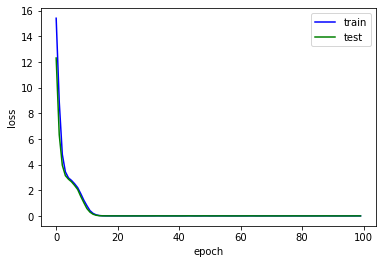

In [47]:
train(model1, n_epochs, ms_old_train, ms_new_train, ms_old_test, ms_new_test,
      answers_train[0], answers_test[0], weight_decay=1e-5)

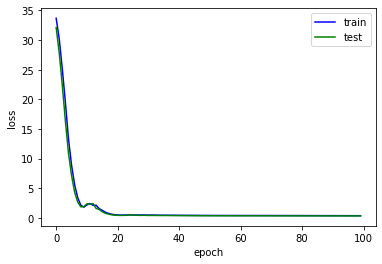

In [48]:
train(model2, n_epochs, ms_old_train, ms_new_train, ms_old_test, ms_new_test,
      answers_train[1], answers_test[1], weight_decay=1e-5)

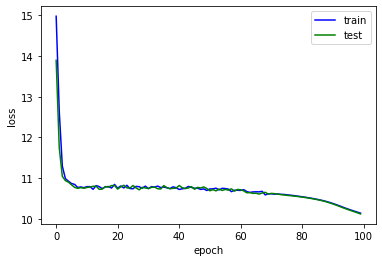

In [49]:
train(model3, n_epochs, ms_old_train, ms_new_train, ms_old_test, ms_new_test,
      answers_train[2], answers_test[2], weight_decay=1e-5)

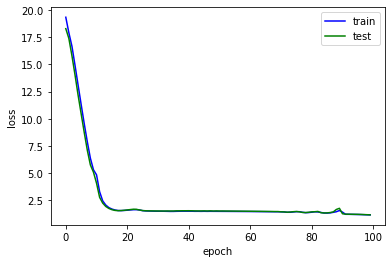

In [50]:
train(model4, n_epochs, ms_old_train, ms_new_train, ms_old_test, ms_new_test,
      answers_train[3], answers_test[3], weight_decay=1e-5)

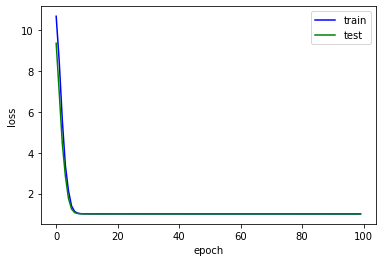

In [51]:
train(model5, n_epochs, ms_old_train, ms_new_train, ms_old_test, ms_new_test,
      answers_train[4], answers_test[4], weight_decay=1e-5)

## Проверка, что модель обучилась как нужно

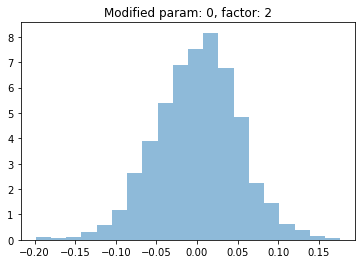

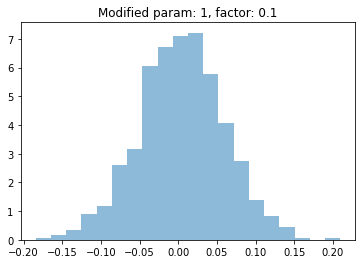

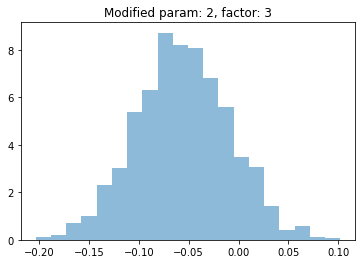

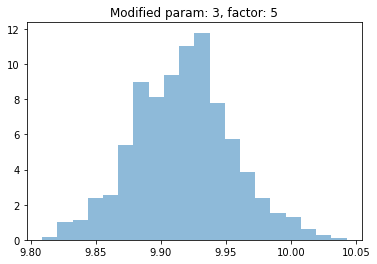

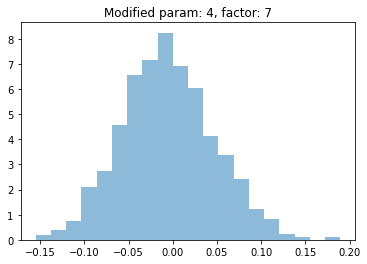

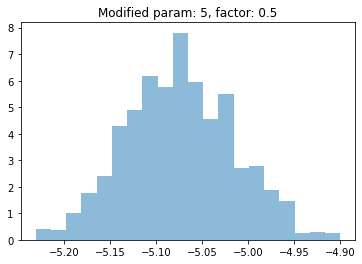

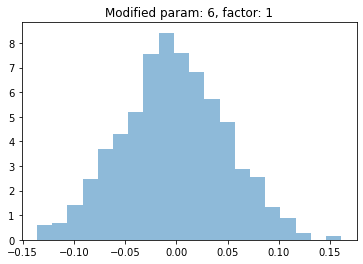

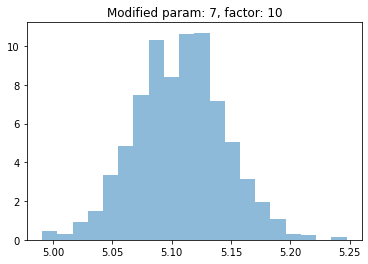

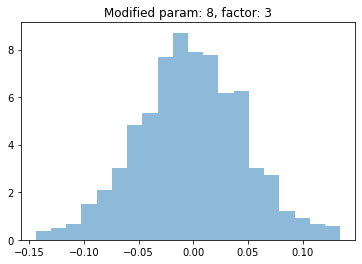

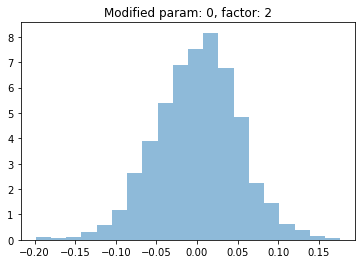

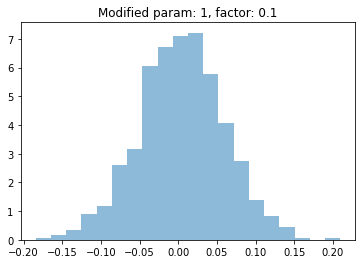

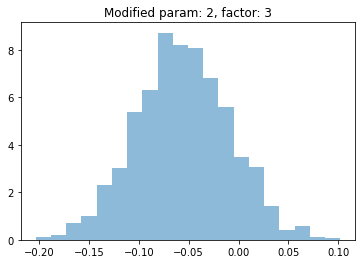

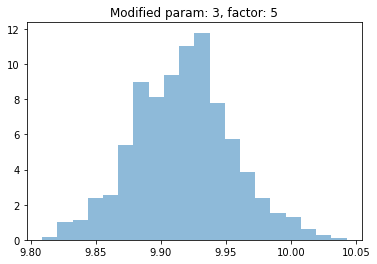

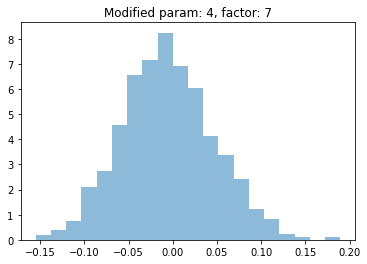

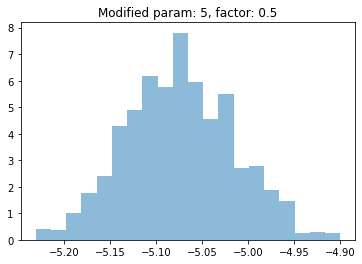

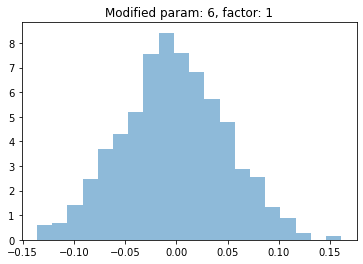

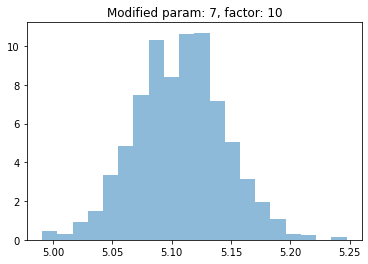

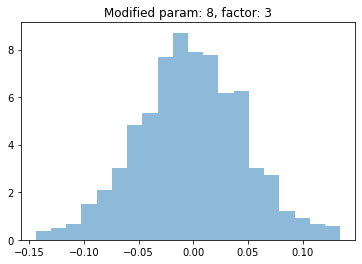

In [71]:
for i in range(len(coeff_ind)):
    coeffs = np.ones_like(init_params)
    coeffs[i] *= coeff_factor[i]
    
    metrics_diff = []

    sim = Simulation()
    sim.add_signals(signals)
    sim.set_params(params)

    sim.add_metrics(metrics)

    for _ in range(N_ITERATIONS):
        sim.set_params(params)
        sim.generate_data()
        metrics_res1 = model1(torch.FloatTensor(sim.conduct_metrics()))

        sim.set_params(params * coeffs)
        sim.generate_data()
        metrics_res2 = model1(torch.FloatTensor(sim.conduct_metrics()))

        metrics_diff.append((metrics_res2 - metrics_res1).item())

    metrics_diff = np.array(metrics_diff)

    fig = plt.figure()
    ax = plt.axes()
    ax.set(title=f'Modified param: {i}, factor: {coeff_factor[i]}')

    ax.hist(metrics_diff, bins='rice', alpha=0.5,
                           histtype='stepfilled', density=True);
    display(fig)
    